#  Tackle Overfitting with Data Augmentation

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

2025-06-27 15:33:32.152873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751018612.241970    4159 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751018612.267276    4159 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751018612.455139    4159 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751018612.455167    4159 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751018612.455169    4159 computation_placer.cc:177] computation placer alr

In [3]:
DATA_DIR = './tensorflow-ai-journey/Intro to tensorflow/horse-or-human'
data_dir_horses = os.path.join(DATA_DIR, 'horses')
data_dir_humans = os.path.join(DATA_DIR, 'humans')

In [4]:
def train_val_datasets():
    training_dataset = tf.keras.utils.image_dataset_from_directory( 
        DATA_DIR,
        image_size=(120, 120),
        batch_size=128,
        label_mode='binary',
        validation_split=0.15,
        subset='training',
        seed=42 
    )
    validation_dataset = tf.keras.utils.image_dataset_from_directory( 
        DATA_DIR,
        image_size=(120, 120),
        batch_size=128,
        label_mode='binary',
        validation_split=0.15,
        subset='validation',
        seed=42 
    )
    return training_dataset, validation_dataset

In [5]:
training_dataset, validation_dataset = train_val_datasets()

Found 1027 files belonging to 2 classes.
Using 873 files for training.
Found 1027 files belonging to 2 classes.
Using 154 files for validation.


2025-06-27 15:33:37.274581: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
FILL_MODE = 'nearest'
def create_augmentation_model():
    augmentation_model = tf.keras.Sequential([ 
        tf.keras.Input(shape=(120, 120, 3)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
        tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode=FILL_MODE),
        tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE)
    ]) 

    return augmentation_model

2025-06-27 15:33:37.647646: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


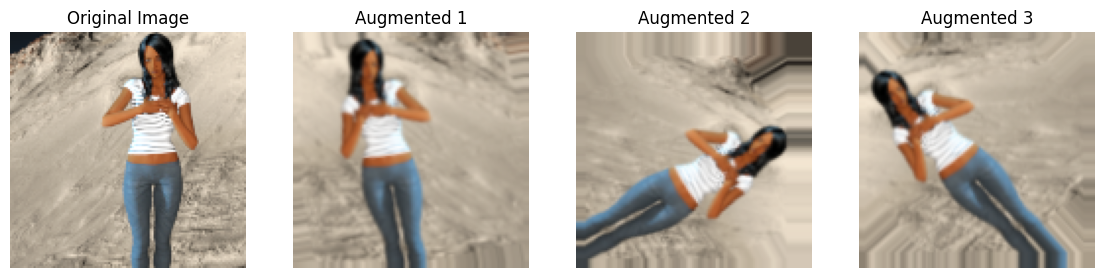

In [7]:
data_augmentor = create_augmentation_model()
for images, labels in training_dataset.take(1):
    example_batch_images = images
    example_batch_labels = labels
sample_image = tf.keras.utils.array_to_img(example_batch_images[0])
images = [sample_image]
for _ in range(3):
    image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0))
    image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
    images.append(image_aug)
fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3']):
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')

plt.show()


In [8]:
def create_model():
    augmentation_layers = create_augmentation_model()

    # Define model using Sequential API
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(120, 120, 3)),
        augmentation_layers,
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(256,(3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        
        # tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        # tf.keras.layers.MaxPooling2D(2,2),
        
        # tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        # tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

  
    model.compile( 
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy'] 
    ) 
    return model

In [9]:

model = create_model()

In [10]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy'] >= 0.8 and logs['val_accuracy'] >= 0.8:
            self.model.stop_training = True

            print("\nReached 80% train accuracy and 80% validation accuracy, so cancelling training!")

In [11]:
history = model.fit(
	training_dataset,
	epochs=5,
	validation_data=validation_dataset,
	callbacks = [EarlyStoppingCallback()]
)

Epoch 1/5


2025-06-27 15:33:40.107036: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 456261632 exceeds 10% of free system memory.
2025-06-27 15:33:45.222726: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 228130816 exceeds 10% of free system memory.
2025-06-27 15:33:45.222777: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 456261632 exceeds 10% of free system memory.


1/7 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step - accuracy: 0.4297 - loss: 0.6993

2025-06-27 15:33:46.564338: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 456261632 exceeds 10% of free system memory.
2025-06-27 15:33:51.648910: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 228130816 exceeds 10% of free system memory.


7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 7s/step - accuracy: 0.4616 - loss: 0.7003 - val_accuracy: 0.4610 - val_loss: 0.7246
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - accuracy: 0.5163 - loss: 0.6908 - val_accuracy: 0.7468 - val_loss: 0.6818
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.6327 - loss: 0.6789 - val_accuracy: 0.7273 - val_loss: 0.6561
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.5850 - loss: 0.6791 - val_accuracy: 0.6883 - val_loss: 0.6472
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step - accuracy: 0.6133 - loss: 0.6519 - val_accuracy: 0.6494 - val_loss: 0.6326
